# Homework 2: linear algebra and numerical calculus

#### Deadline: Wednesday 26 July 2023 (by the end of the day)

#### Credits: 20 points

## Name: Gabriel Balarezo

- When you finish, please send me the **.ipynb** file via email to wbanda@yachaytech.edu.ec



- This homework is **individual**. Please include your name in the notebook.



- Within a **single python notebook**, solve the following problems:

## Problem statement: shock-cloud interaction

Shock waves are flow discontinuities that arise in supersonic gases when the local flow speed exceeds the sound speed of the gas. When shocks interact with gas clouds, they can accelerate them and disrupt them.

Here, we numerically study one of such interactions where a shock wave propagates across a 2D computational domain (along the Y-axis from the bottom to the top), interacting with a cylindrical cloud in slab geometry. In the simulation, the cloud gas is tracked with a pigment (tracer).

The flow is adiabatic (the polytropic index is $\gamma=\frac{5}{3}$), the gas is ionised (the mean particle mass is $\mu = 0.6$), and the gas is also magnetised (the magnetic field is initially perpendicular to the flow, so it is oriented along the X-axis).

The shock-cloud numerical simulation produces $61$ VTK files stored in:

- the **MHD-shock-cloud** folder: 

https://github.com/wbandabarragan/computational-physics-1/blob/main/assignments/data_sets/MHD-shock-cloud.zip

jointly with:

- a **units.out** file that contains the CGS normalisation values.
- a **vtk.out** file whose second column contains the times in code units.
- a **grid.out** file that contains information on the grid structure.

You can use VisIt to inspect the data.

## 1. (5 points) 2D data I/O and visualisation

Create a set of Python functions that:

(a) opens the **units.out** file, stores the normalisation values for length, velocity, density, pressure, magnetic field and time into callable objects, and then returns them.

**Note:**

The normalisation values for thermal pressure ($p_0=\rho_0\,v_0^2$), magnetic field ($B_0=\sqrt{4\,\pi\,\rho_0\,v_0^2}$), and time ($t_0=\frac{L_0}{v_0}$) can be derived from the length, velocity, and density values.

(b) opens the **VTK** file # 35, reads the data arrays, and returns the 2D, CGS-normalised arrays for:

- density (rho)
- thermal pressure (prs)
- pigment (tr1)
- velocity_x (vx1)
- velocity_y (vx2)
- magnetic_field_x (Bx1)
- magnetic_field_y (Bx2)

**Notes:**

- The pigment tr1 does not need to be normalised as it is just a dimensionless colour. Initially, the pigment/tracer tr1 is 1 for cloud gas and 0 everywhere else, so it effectively tracks the cloud gas.

- Use the normalisation values returned by the function from part **(a)** to convert fron code units to CGS units.

(c) reads the 2D arrays returned by the function above, interpolates them into a CGS-normalised meshgrid created with the mesh information stored in the VTK files, and exports 4 figures containing maps of:

- density
- thermal pressure
- velocity
- magnetic field

**Note:**

Choose different perceptually-uniform colour schemes for each of the above quantities.

In [1]:
# Fist, let's import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import os
from skimage.transform import rescale
import glob 
from IPython import display
from PIL import Image 

### (a) 
opens the **units.out** file, stores the normalisation values for length, velocity, density, pressure, magnetic field and time into callable objects, and then returns them.

**Note:**

The normalisation values for thermal pressure ($p_0=\rho_0\,v_0^2$), magnetic field ($B_0=\sqrt{4\,\pi\,\rho_0\,v_0^2}$), and time ($t_0=\frac{L_0}{v_0}$) can be derived from the length, velocity, and density values.

In [2]:
# Define a function to read the units.out file 

def units(directory, file_name):
    """
    This function reads the units.out file 
    and returns the normalisation values 
    stored on it.
    Input: directory, file_name
    Output: L_0, v_0, rho_0, p_0, B_0, t_0
    """
    
    # Put the data into a pandas dataframe
    df_units = pd.read_csv(directory + file_name)
    
    # read the units and put them into numpy arrays
    rho_0 = np.array(df_units.loc[df_units["variable"] == 'rho_0']['normalisation'])
    v_0 = np.array(df_units.loc[df_units["variable"] == 'v_0']['normalisation'])
    L_0 = np.array(df_units.loc[df_units["variable"] == 'L_0']['normalisation'])
    
    # Compute the other normalisation quantities
    p_0 = rho_0 * v_0**2
    B_0 = v_0 * np.sqrt(4 * np.pi * rho_0)
    t_0 = L_0/v_0
    
    return L_0, v_0, rho_0, p_0, B_0, t_0

In [3]:
# Calling the function

# Define the directory 
directory = "./MHD-shock-cloud/"

L_0, v_0, rho_0, p_0, B_0, t_0 = units(directory , "units.out")

In [4]:
# Report the normalisation units

print("L_0 [cm]: ", L_0)
print("v_0 [cm/s]: ", v_0)
print("rho_0 [g/cm^3]: ", rho_0)
print("p_0 [barye]: ", p_0)
print("B_0 [G]: ", B_0)
print("t_0 [s]: ", t_0)

L_0 [cm]:  [3.086e+19]
v_0 [cm/s]:  [10000000.]
rho_0 [g/cm^3]:  [1.661e-24]
p_0 [barye]:  [1.661e-10]
B_0 [G]:  [4.56866956e-05]
t_0 [s]:  [3.086e+12]


### (b) 
opens the **VTK** file # 35, reads the data arrays, and returns the 2D, CGS-normalised arrays for:

- density (rho)
- thermal pressure (prs)
- pigment (tr1)
- velocity_x (vx1)
- velocity_y (vx2)
- magnetic_field_x (Bx1)
- magnetic_field_y (Bx2)

**Notes:**

- The pigment tr1 does not need to be normalised as it is just a dimensionless colour. Initially, the pigment/tracer tr1 is 1 for cloud gas and 0 everywhere else, so it effectively tracks the cloud gas.

- Use the normalisation values returned by the function from part **(a)** to convert fron code units to CGS units.

In [5]:
# Let's open the file in order to see the way data is organised

# Get the data into a mesh
mesh = pv.read(directory + "data.0035.vtk")

print(mesh)
print(mesh.array_names)

RectilinearGrid (0x7f9626b87d60)
  N Cells:      65536
  N Points:     66049
  X Bounds:     -8.000e+00, 8.000e+00
  Y Bounds:     -2.000e+00, 1.400e+01
  Z Bounds:     0.000e+00, 0.000e+00
  Dimensions:   257, 257, 1
  N Arrays:     7
['rho', 'vx1', 'vx2', 'Bx1', 'Bx2', 'prs', 'tr1']


In [6]:
# Fist, let's define de function 

def io_data(filename):
    """
    I/O function: This function reads a vtk file, and returns normalised 
    2D columns in cgs units.
    Input: filename
    Output: rho_cgs2D, prs_cgs2D, pigment_cgs2D, vx1_cgs2D, vx2_cgs2D, Bx1_cgs2D, Bx2_cgs2D
    """
    
    # Opening the mesh
    mesh1 = pv.read(filename)
    
    # Getting the data arrays
    rho = pv.get_array(mesh1, "rho", preference = 'cell') #density in code units
    prs = pv.get_array(mesh1, "prs", preference = "cell") # thermal pressure in code units
    pigment = pv.get_array(mesh1, "tr1", preference = 'cell') # pigment (dimensionless)
    vx1 = pv.get_array(mesh1, "vx1", preference = 'cell') #vx in code units
    vx2 = pv.get_array(mesh1, "vx2", preference = 'cell') #vy in code units    
    Bx1 = pv.get_array(mesh1, "Bx1", preference = "cell") #Bx in code units 
    Bx2 = pv.get_array(mesh1, "Bx2", preference = "cell") #By in code units 

    
    # Convert the arrays to 2D
    rho_2D = rho.reshape(mesh1.dimensions[0] - 1, mesh1.dimensions[1] - 1)
    prs_2D = prs.reshape(mesh1.dimensions[0] - 1, mesh1.dimensions[1] - 1)
    pigment_2D = pigment.reshape(mesh1.dimensions[0] - 1, mesh1.dimensions[1] - 1)
    vx1_2D = vx1.reshape(mesh1.dimensions[0] - 1, mesh1.dimensions[1] - 1)
    vx2_2D = vx2.reshape(mesh1.dimensions[0] - 1, mesh1.dimensions[1] - 1)
    Bx1_2D = Bx1.reshape(mesh1.dimensions[0] - 1, mesh1.dimensions[1] - 1)
    Bx2_2D = Bx2.reshape(mesh1.dimensions[0] - 1, mesh1.dimensions[1] - 1)

    
    # Convert arrays to CGS units
    rho_cgs2D = np.array(rho_2D * rho_0)
    prs_cgs2D = np.array(prs_2D * p_0)
    pigment_cgs2D = np.array(pigment_2D) # no normalisation units 
    vx1_cgs2D = np.array(vx1_2D * v_0)
    vx2_cgs2D = np.array(vx2_2D * v_0)
    Bx1_cgs2D = np.array(Bx1_2D * B_0)
    Bx2_cgs2D = np.array(Bx2_2D * B_0)


    return rho_cgs2D, prs_cgs2D, pigment_cgs2D, vx1_cgs2D, vx2_cgs2D, Bx1_cgs2D, Bx2_cgs2D

In [7]:
# Call the function 

rho_cgs2D, prs_cgs2D, pigment_cgs2D, vx1_cgs2D, vx2_cgs2D, Bx1_cgs2D, Bx2_cgs2D = io_data(directory + "data.0035.vtk")

# check 
#print(vx1_cgs2D)
#print(rho_cgs2D)

### (c)
reads the 2D arrays returned by the function above, interpolates them into a CGS-normalised meshgrid created with the mesh information stored in the VTK files, and exports 4 figures containing maps of:

- density
- thermal pressure
- velocity
- magnetic field

**Note:**

Choose different perceptually-uniform colour schemes for each of the above quantities.

In [8]:
# Create the normalised meshgrid 

# Create coordinate vectors
X = np.linspace(mesh.bounds[0], mesh.bounds[1], (mesh.dimensions[0])) * L_0
Y = np.linspace(mesh.bounds[2], mesh.bounds[3], (mesh.dimensions[1])) * L_0 

# Generate a meshgrid
X_2D, Y_2D = np.meshgrid(X, Y)

#print(X.shape) 
#print(vx1_cgs2D.shape)

In [9]:
# Generate the required maps

In [10]:
# Let's reshape the magnetic field and velocity field vectors
n = 0.10

# Resizing the meshgrid
X_2D_res = rescale(X_2D, n)
Y_2D_res = rescale(Y_2D, n)

# define a function to resize the vector fields 

def rescale_function(x1, x2, n):
    """
    Function to resize a vector field.
    Input: vector components (x1, x2), n (new size).
    Output: x1_res, x2_res
    """
    # Rescale the components
    x1_res = rescale(x1, n)
    x2_res = rescale(x2, n)
    
    mag_x = np.sqrt(x1**2 + x2**2)
    
    # Rescale the magnitude
    mag_x_res = rescale(mag_x, n)
    
    return x1_res, x2_res, mag_x_res

# Resizing magnetic field
Bx1_res, Bx2_res, mod_B_res = rescale_function(Bx1_cgs2D, Bx2_cgs2D, n)
# Resizing velocity field 
vx1_res, vx2_res, mod_v_res = rescale_function(vx1_cgs2D, vx2_cgs2D, n)


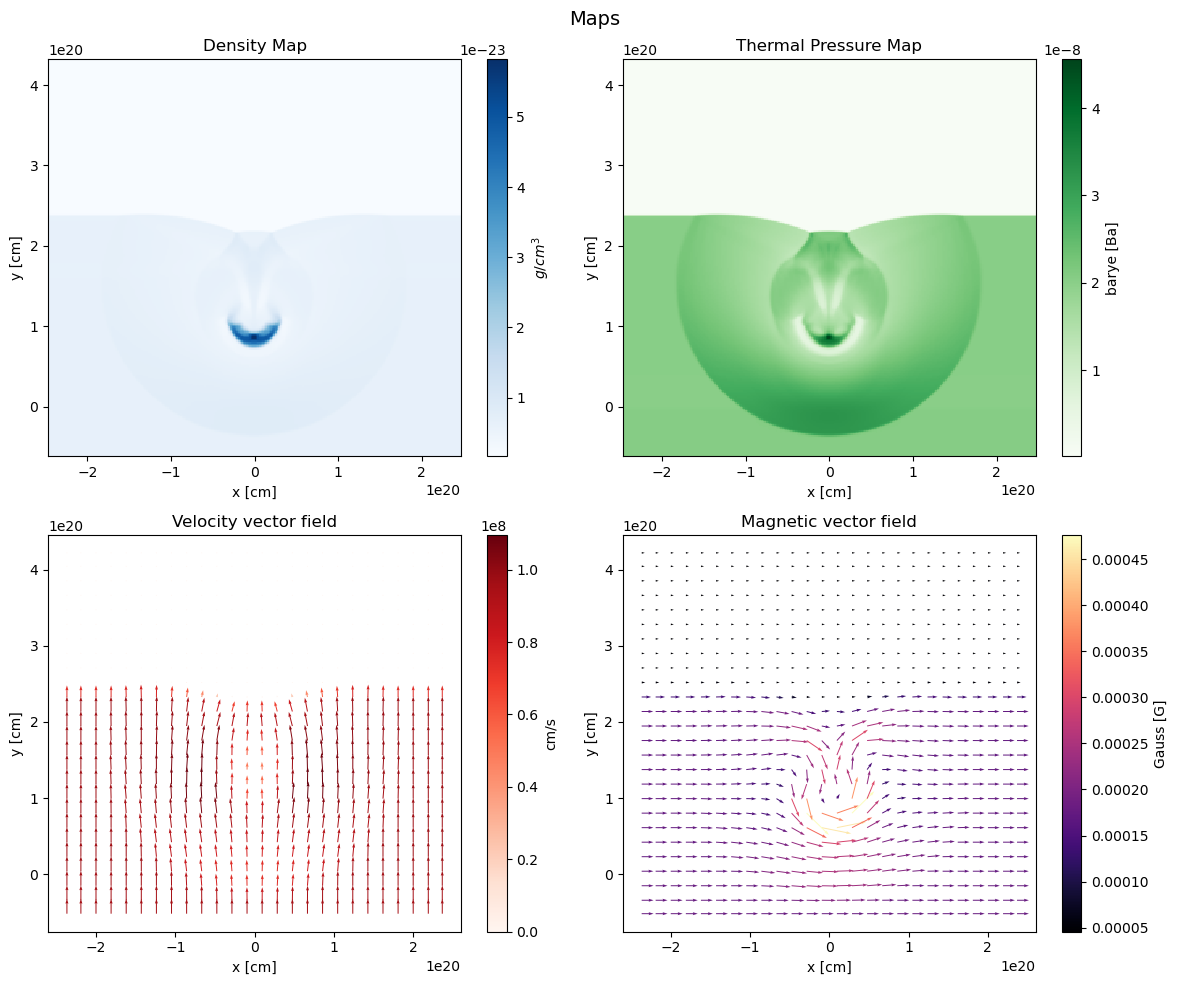

In [48]:
# Create a new figure
fig = plt.figure(figsize=(12, 10))

# Density
ax1 = fig.add_subplot(2, 2, 1)
z1 = ax1.pcolor(X_2D, Y_2D, rho_cgs2D, cmap = "Blues")
ax1.set_title("Density Map")
ax1.set_xlabel("x [cm]")
ax1.set_ylabel("y [cm]")
cl1 = plt.colorbar(z1)
cl1.set_label(r"$g/cm^3$")

# Pressure
ax2 = fig.add_subplot(2, 2, 2)
z2 = ax2.pcolor(X_2D, Y_2D, prs_cgs2D, cmap = "Greens")
cl2 = plt.colorbar(z2)
ax2.set_title("Thermal Pressure Map")
ax2.set_xlabel("x [cm]")
ax2.set_ylabel("y [cm]")
cl2.set_label("barye [Ba]")

# Velocity 
ax3 = fig.add_subplot(2, 2, 3)
z3 = ax3.quiver(X_2D_res, Y_2D_res, vx1_res, vx2_res, mod_v_res, cmap = "Reds")
cl3 = plt.colorbar(z3)
ax3.set_title("Velocity vector field")
ax3.set_xlabel("x [cm]")
ax3.set_ylabel("y [cm]")
cl3.set_label("cm/s")

# Magnetic field 
ax4 = fig.add_subplot(2, 2, 4)
z4 = ax4.quiver(X_2D_res, Y_2D_res, Bx1_res, Bx2_res, mod_B_res, cmap = "magma")
cl4 = plt.colorbar(z4)
ax4.set_title("Magnetic vector field")
ax4.set_xlabel("x [cm]")
ax4.set_ylabel("y [cm]")
cl4.set_label("Gauss [G]")

plt.suptitle("Maps", fontsize = 14)

# Adjust layout to prevent overlapping titles and labels
fig.tight_layout()

# Show the plot
plt.show()

## 2. (5 points) Image analysis: isolating features and derivatives

For the same VTK file (# 35), create a set of Python functions that:

(a) Isolate the cloud gas based on the following algorithm:

- Read the 2D density (rho) and pigment (tr1) arrays.

- Isolate the densities of grid cells that contain only pigment values tr1 > 0.05 (you can use conditionals to get the cell indices first).

(b) Make a map of the resulting density of cloud gas only.

(c) Isolate candidate shocked cells based on the following methods:

- **Method 1:** Read the 2D velocity vector field. Compute the divergence of the velocity field and isolate the cells where there are convergent flows (i.e. where $\vec\nabla\cdot \vec v <0$). Cells with convergent flows are candidate shocked cells.



- **Method 2:** Read the 2D pressure field. Compute the gradient of the pressure and isolate the cells with large pressure gradients (i.e. where $\frac{|\vec\nabla P|}{P}>0.01\max{\left(\frac{|\vec\nabla P|}{P}\right)}$). Such cells are candidate shocked cells.

(d) Make binary maps of the resulting candidate shock cells from both methods. Overall, do you find the same shock candidates on these maps? Label the main shock on these maps.


### (a)
Isolate the cloud gas based on the following algorithm:

- Read the 2D density (rho) and pigment (tr1) arrays.

- Isolate the densities of grid cells that contain only pigment values tr1 > 0.05 (you can use conditionals to get the cell indices first).

In [12]:
# Read the arrays 

# Function to clean the data
rho_cloud = lambda pigment, rho:np.where(pigment <= 0.05, 0, rho)

In [13]:
rho_clean = rho_cloud(pigment_cgs2D, rho_cgs2D)

### (b)
Make a map of the resulting density of cloud gas only.

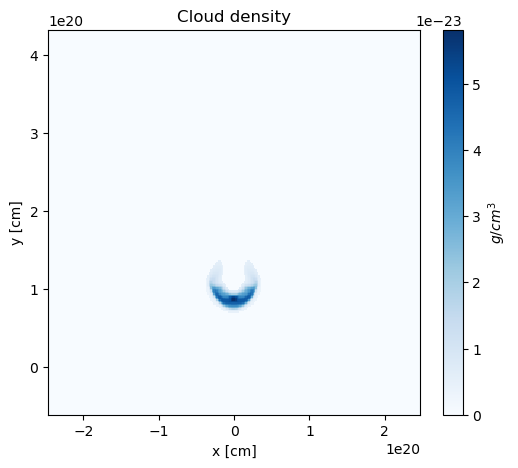

In [14]:
# fig env
fig, ax = plt.subplots(figsize = (6, 5))

#plot 
z = ax.pcolor(X_2D, Y_2D, rho_clean, cmap = "Blues")
clb = plt.colorbar(z)
ax.set_title("Cloud density")
ax.set_xlabel("x [cm]")
ax.set_ylabel("y [cm]")

clb.set_label(r"$g/cm^3$")

    
plt.show()

### (c)
Isolate candidate shocked cells based on the following methods:

- **Method 1:** Read the 2D velocity vector field. Compute the divergence of the velocity field and isolate the cells where there are convergent flows (i.e. where $\vec\nabla\cdot \vec v <0$). Cells with convergent flows are candidate shocked cells.



- **Method 2:** Read the 2D pressure field. Compute the gradient of the pressure and isolate the cells with large pressure gradients (i.e. where $\frac{|\vec\nabla P|}{P}>0.01\max{\left(\frac{|\vec\nabla P|}{P}\right)}$). Such cells are candidate shocked cells.

In [15]:
# define the x spacing 
dx = float(X[1] - X[0])

In [16]:
# Method 1 

# define a function to compute the divergence of a vector
def get_divergence(comp1, comp2, dx):
    """
    Function to get div of any vector.
    """
    div1 = np.gradient(comp1, dx, axis = 1)
    div2 = np.gradient(comp2, dx, axis = 0)
    
    divt = div1 + div2
    
    return divt

In [17]:
# Call our div function

div_vfield = get_divergence(vx1_cgs2D, vx2_cgs2D, dx)

In [18]:
# Method 2
# compute the gradient of the  2D pressure field
def gradient(scalar, dx):
    """
    Function to get the grad of a scalar field.
    Input: scalar, dx
    Output: grad_vec
    """
    grad_vec = np.gradient(scalar, dx)
    
    return grad_vec

In [19]:
# Call the grad function 
grad_prs = gradient(prs_cgs2D, dx)

# Get the modulus of the gradient 
mag_grad_prs = np.sqrt(grad_prs[0]**2 + grad_prs[1]**2)

#### Isolate the candidate cells for the two methods

In [20]:
# define a function to isolate the candidate cells for the two methods 

def shock_cells(div_field, grad_field, mag_grad, prs):
    '''
    Function to isolate the candidate shock cells.
    Input: div_field, grad_field, mag_grad, prs
    Output: candidate_cells_1, candidate_cells_2
    '''
    
    # Method 1 
    candidate_cells_1 = np.where(div_field >= -0.1e-11, np.nan, 1)


    # Candidate cells method 2
    # compute the max of mag_grad/prs_cgs2D
    max_prs = np.max((mag_grad/prs))

    # define the threshold
    threshold = 0.01 * max_prs

    # isolate the candidate cells
    candidate_cells_2 = np.where((mag_grad/prs) <= threshold, np.nan, 1)
    
    return candidate_cells_1, candidate_cells_2

In [21]:
# calling the function 
shock_cells1, shock_cells2 = shock_cells(div_vfield, grad_prs, mag_grad_prs, prs_cgs2D)

### (d)
Make binary maps of the resulting candidate shock cells from both methods. Overall, do you find the same shock candidates on these maps? Label the main shock on these maps.

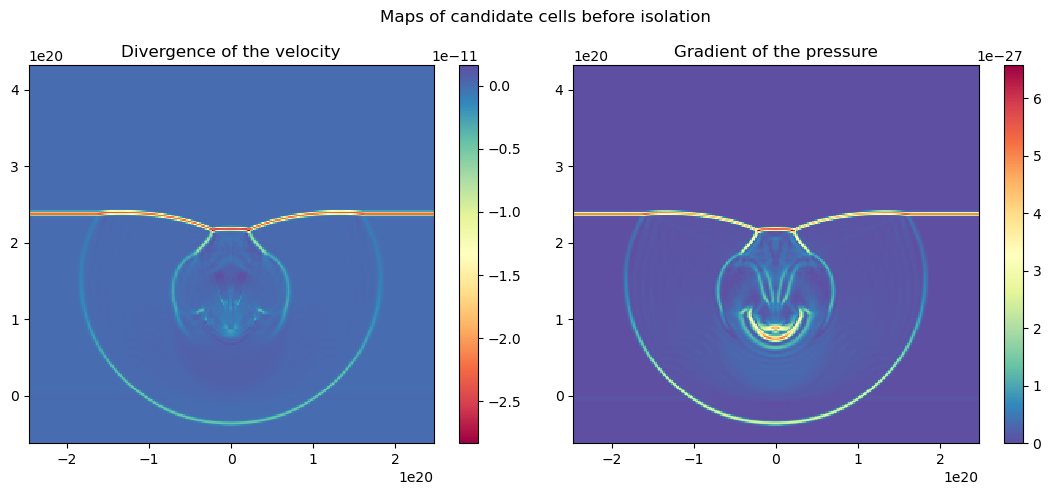

In [22]:
# Plotting maps before isolation 

# Create your first figure
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

# Method 1 results
p1 = ax[0].pcolor(X_2D, Y_2D, div_vfield, cmap = 'Spectral', shading = 'auto')
cb1 = fig.colorbar(p1, ax=ax[0])

# set title
ax[0].set_title('Divergence of the velocity')


# Method 2 results
p2 = ax[1].pcolor(X_2D, Y_2D, mag_grad_prs, cmap = 'Spectral_r', shading = 'auto')
cb2 = fig.colorbar(p2, ax=ax[1])

# set title
ax[1].set_title("Gradient of the pressure")

plt.suptitle("Maps of candidate cells before isolation")
# Adjust the spacing between subplots
plt.tight_layout()

plt.show()

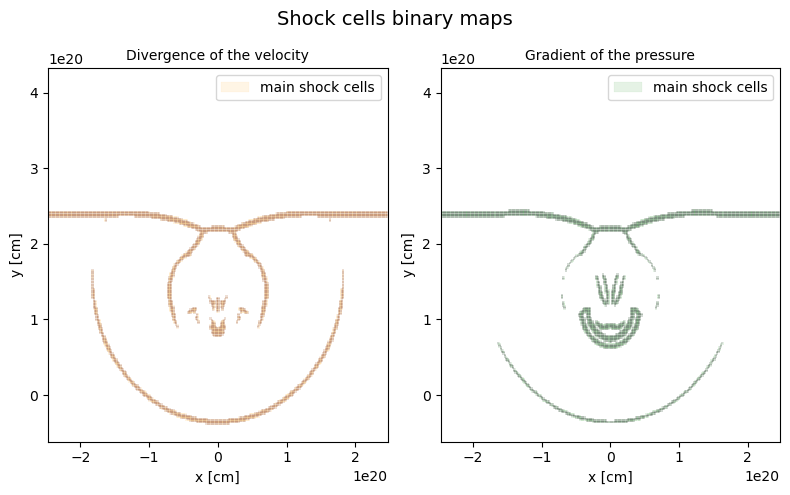

In [23]:
# maps with isolated candidate cells 

# Create your first figure
fig, ax = plt.subplots(1, 2, figsize=(8, 5))

# Method 1 results
ax[0].pcolor(X_2D, Y_2D, shock_cells1, color = 'orange', alpha = 0.1, label = 'main shock cells')
ax[0].set_xlabel("x [cm]")
ax[0].set_ylabel("y [cm]")
# set title
ax[0].set_title('Divergence of the velocity', fontsize = 10)
ax[0].legend(loc='best')

# Method 2 results
ax[1].pcolor(X_2D, Y_2D, shock_cells2, color = "green", alpha = 0.1, label = 'main shock cells')
ax[1].set_xlabel("x [cm]")
ax[1].set_ylabel("y [cm]")
# set title
ax[1].set_title("Gradient of the pressure", fontsize = 10)
ax[1].legend(loc='best')


plt.suptitle("Shock cells binary maps", fontsize = 14)

# Adjust the spacing between subplots
plt.tight_layout()

plt.show()

As we can see, the results are almost the same. Althoug using the first method (divergence of the velocity) we do not get the same shock cells as those we get in the second method, in the other regions we get similar results using the two methods. 

# 3. (5 points) Python loops: full data analysis

Create a set of Python functions that:

(a) Read the second column of the **vtk.out** file into a time array, normalises these times using the normalisation time computed in problem 1, and then returns a CGS-normalised time array.


(b) Loop over all the simulation VTK files (0 to 60), calls all the functions written for problems 1 and 2, and then prints the resulting maps into two folders called:

1. **"maps"**, which should contain the figures for density, thermal pressure, velocity, and magnetic field for all the times (add a CGS time-stamp to each map).

2. **"features"**, which should contain the figures for cloud density and candidate shocked cells (from both methods) for all the times (add a CGS time-stamp to each map).

**Note:** Fix the min/max values of the colourbars, so that maps at different times can be compared with one another.

(c) Return a movie showing the time evolution of the magnetic field. What happens to the magnetic field as time progresses?

**Note:** Since there are $256^2$ cells in this simulation, one way to improve the visualisation of 2D vector fields is to interpolate them into a coarser grid.

### (a)
Read the second column of the **vtk.out** file into a time array, normalises these times using the normalisation time computed in problem 1, and then returns a CGS-normalised time array.

In [24]:
# Now. let's get the times from the vtk.out file
file_name_2 = "vtk.out"

time_data = pd.read_csv(directory + file_name_2, sep='\s+', header=None)

time_code = time_data.iloc[:,1]

# Get time in CGS units 
time_cgs = time_code * t_0

#print(time_cgs)

### (b)
Loop over all the simulation VTK files (0 to 60), calls all the functions written for problems 1 and 2, and then prints the resulting maps into two folders called:

1. **"maps"**, which should contain the figures for density, thermal pressure, velocity, and magnetic field for all the times (add a CGS time-stamp to each map).

2. **"features"**, which should contain the figures for cloud density and candidate shocked cells (from both methods) for all the times (add a CGS time-stamp to each map).

**Note:** Fix the min/max values of the colourbars, so that maps at different times can be compared with one another.


In [25]:
# Let's create the maps directory
if os.path.isdir("./maps"):
    print("Directory already exists.")
else: 
    print("Directory has been created.")
    os.mkdir("./maps")

maps_directory = "./maps/"

Directory already exists.


In [26]:
# Let's create the maps directory
if os.path.isdir("./features"):
    print("Directory already exists.")
else: 
    print("Directory has been created.")
    os.mkdir("./features")

features_directory = "./features/"

Directory already exists.


In [27]:
# Loop over all the files (maps)

for i in range(0,len(time_cgs)):
    
    # Define the filename 
    file = directory + "data.0{:03d}.vtk".format(i) 
    
    # Call the function
    rho_cgs2D1, prs_cgs2D1, pigment_cgs2D1, vx1_cgs2D1, vx2_cgs2D1, Bx1_cgs2D1, Bx2_cgs2D1 = io_data(file)
    
    # calling the resize function for the vector fields 
    
    # Resizing magnetic field
    Bx1_res1, Bx2_res1, mod_B1_res = rescale_function(Bx1_cgs2D1, Bx2_cgs2D1, n)
    # Resizing velocity field 
    vx1_res1, vx2_res1, mod_v1_res = rescale_function(vx1_cgs2D1, vx2_cgs2D1, n)
    
    
    # Generating the maps 
   
    fig = plt.figure(figsize=(12, 10))

    # Density 
    ax1 = fig.add_subplot(2, 2, 1)
    z1 = ax1.pcolor(X_2D, Y_2D, rho_cgs2D1, cmap = "Blues", vmin = 0, vmax = 1e-23)
    ax1.set_title("Density Map")
    ax1.set_xlabel("x [cm]")
    ax1.set_ylabel("y [cm]")
    clb1 = plt.colorbar(z1)
    clb1.set_label(r"$g/cm^3$")

    # Thermal pressure
    ax2 = fig.add_subplot(2, 2, 2)
    z2 = ax2.pcolor(X_2D, Y_2D, prs_cgs2D1, cmap = "Greens", vmin = 0, vmax = 4e-8)
    clb2 = plt.colorbar(z2)
    ax2.set_title("Thermal Pressure Map")
    ax2.set_xlabel("x [cm]")
    ax2.set_ylabel("y [cm]")
    clb2.set_label("barye [Ba]")
    
    # Velocity vector field
    ax3 = fig.add_subplot(2, 2, 3)
    z3 = ax3.quiver(X_2D_res, Y_2D_res, vx1_res1, vx2_res1, mod_v1_res, cmap = "Reds", clim = (0, 1e8))
    clb3 = plt.colorbar(z3)
    ax3.set_title("Velocity vector field")
    ax3.set_xlabel("x [cm]")
    ax3.set_ylabel("y [cm]")
    clb3.set_label("cm/s")
    
    # Magnetic field field 
    ax4 = fig.add_subplot(2, 2, 4)
    z4 = ax4.quiver(X_2D_res, Y_2D_res, Bx1_res1, Bx2_res1, mod_B1_res, cmap = "Oranges", clim = (0, 0.0008))
    clb4 = plt.colorbar(z4)
    ax4.set_title("Magnetic vector field")
    ax4.set_xlabel("x [cm]")
    ax4.set_ylabel("y [cm]")
    clb4.set_label("Gauss [G]")
    
    fig.suptitle(f'Time [s]: {time_cgs[i]}')

    # Adjust layout to prevent overlapping titles and labels
    fig.tight_layout()
    
    # Save the figure
    plt.savefig(maps_directory + "Maps{:03d}.png".format(i))
    plt.close()
    
    ##########################################################
    # Creating the features plots 
    # cleaning the density data 
    rho_clean1 = np.where(pigment_cgs2D1 <= 0.05, 0, rho_cgs2D1)
    
    # Cloud density plot
    fig, ax = plt.subplots(figsize = (6, 5))
    z = ax.pcolor(X_2D, Y_2D, rho_clean1, cmap = "Blues", vmin = 0, vmax = 6e-23)
    clb5 = plt.colorbar(z)
    ax.set_title(f"Cloud density [Time (s): {time_cgs[i]}]")
    ax.set_xlabel("x [cm]")
    ax.set_ylabel("y [cm]")
    clb5.set_label("g/cm^3")
    
    # Save the figure
    plt.savefig(features_directory + "Cloud_Density{:03d}.png".format(i))
    plt.close()
    
    # Plots of the candidate shock cells 
    # call divergence function 
    div_vfield1 = get_divergence(vx1_cgs2D1, vx2_cgs2D1, dx)
    
    # Call the grad function 
    grad_prs1 = gradient(prs_cgs2D1, dx)

    # Get the modulus of the gradient 
    mag_grad_prs1 = np.sqrt(grad_prs1[0]**2 + grad_prs1[1]**2)
    
    # Get the shock cells 
    shock_cells_1, shock_cells_2 = shock_cells(div_vfield1, grad_prs1, mag_grad_prs1, prs_cgs2D1)
    
    # Plot 
    fig, ax = plt.subplots(1, 2, figsize=(8, 5))
    
    # Method 1 results
    p1 = ax[0].pcolor(X_2D, Y_2D, shock_cells_1, color = 'orange', alpha = 0.1 , vmin = -2.5e-11, vmax = 0, label = "main shock cells")
    ax[0].set_xlabel("x [cm]")
    ax[0].set_ylabel("y [cm]")
    # set title
    ax[0].set_title('Divergence of the velocity', fontsize = 10)
    ax[0].legend(loc='best')

    # Method 2 results
    p2 = ax[1].pcolor(X_2D, Y_2D, shock_cells_2, color = "green", alpha = 0.1, vmin = 0, vmax = 2, label = "main shock cells")
    ax[1].set_xlabel("x [cm]")
    ax[1].set_ylabel("y [cm]")
    # set title
    ax[1].set_title("Gradient of the pressure", fontsize = 10)
    ax[1].legend(loc='best')
    
    plt.suptitle(f"Shock cells [Time (s): {time_cgs[i]}]")
    # Adjust the spacing between subplots
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(features_directory + "Shock_cells{:03d}.png".format(i))
    plt.close()

### (c)
Return a movie showing the time evolution of the magnetic field. What happens to the magnetic field as time progresses?

**Note:** Since there are $256^2$ cells in this simulation, one way to improve the visualisation of 2D vector fields is to interpolate them into a coarser grid.

In [28]:
# Let's create the directory for magnetic field maps
if os.path.isdir("./B_plots"):
    print("Directory already exists.")
else: 
    print("Directory has been created.")
    os.mkdir("./B_plots")

B_directory = "./B_plots/"

Directory already exists.


In [49]:
# Loop over all the files 
for i in range(0,len(time_cgs)):
    
    # Define the filename 
    file = directory + "data.0{:03d}.vtk".format(i) 
    
    # Call the function
    output = io_data(file)
    
    # calling the resize function for the vector fields 
    
    # Resizing magnetic field
    Bx1_res2, Bx2_res2, mod_B2_res = rescale_function(output[5], output[6], n)
    
    # Plotting 
    fig, ax = plt.subplots(figsize = (10, 8))
    p1 = ax.quiver(X_2D_res, Y_2D_res, Bx1_res2, Bx2_res2, mod_B2_res, cmap = "magma", clim = (0, 0.0008))
    clb = plt.colorbar(p1)
    ax.set_xlabel("x [cm]")
    ax.set_ylabel("y [cm]")
    ax.set_title(f"Magnetic vector field [Time (s): {time_cgs[i]}]")
    clb.set_label("Gauss [G]")
    
    plt.savefig(B_directory + "Magnetic_Field{:03d}.png".format(i))
    
    plt.close() 

In [50]:
# Create the animation 
images_input = "./B_plots/Magnetic_Field***.png"
imgif_output = "./Magnetic_Field_evolution.gif"

# Collect the images 
imgs = (Image.open(f) for f in sorted(glob.glob(images_input)))

img = next(imgs)

img.save(fp = imgif_output, format = "GIF", append_images = imgs,\
         save_all = True, duration = 60, loop = 0)

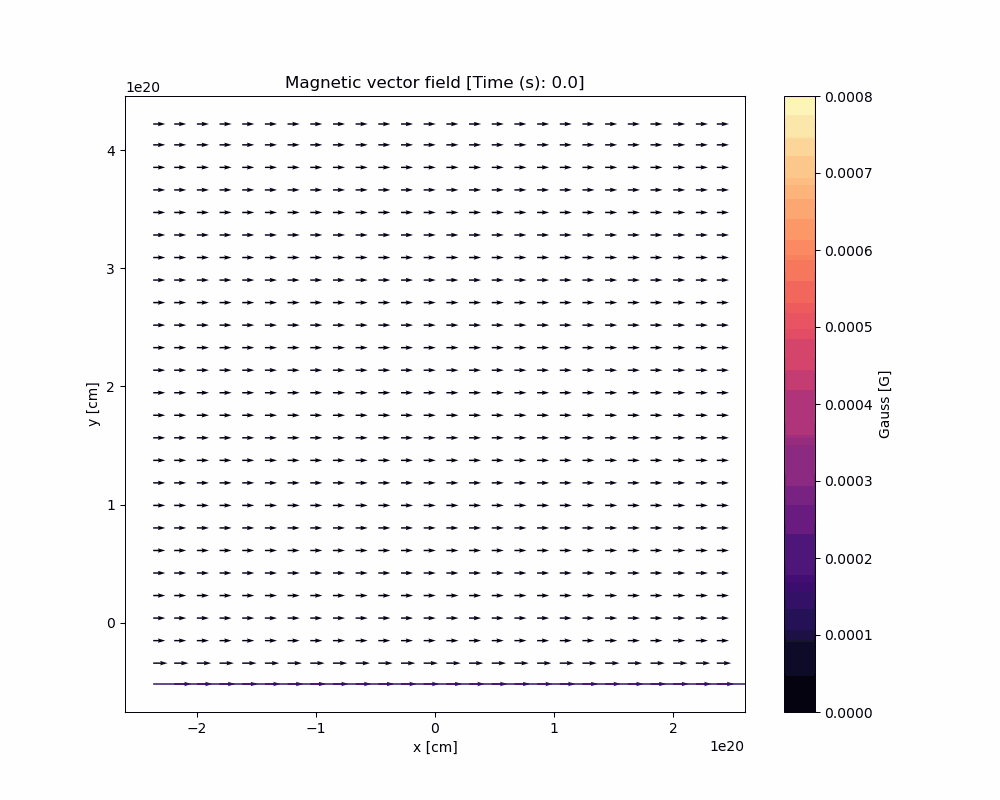

In [51]:
display.Image("./Magnetic_Field_evolution.gif")

As time progresses, the magnitude of the magnetic field increases, while its direction keeps unaffected. Besides, we can see that as the magnetic field crosses the cloud, it becomes almost zero.  We can also notice that the magnetic field is higher in high pressure zones, for example that one where the shock interacts with the gas cloud.

## 4. (5 points) Numerical calculus and time evolution

Create a set of Python functions that:

(a) Loop over all the simulation VTK files ($0$ to $60$), computes the following quantities for each time:

- the total cloud mass ($m_{cloud}$).
- the cloud mass loss rate ($\dot{m}_{cloud}$)
- position of the centre of mass of the cloud ($r_{cloud}$)
- mass-weighted velocity of cloud ($v_{cloud}$)
- acceleration of the cloud ($\dot{v}_{cloud}$)

and returns a CSV file with $6$ columns, time on the first column, and the above quantities in the next ones.

**Notes:**
- Before coding you should write down the equations needed to compute the above quantities. Some of them involve integrals, others derivatives.

- Use the cloud tracer (tr1) as a weight to get the cloud cells.

- The simulation is 2D. Thus, to obtain the correct units for some of the above integrated quantities, you can safely assume that the differential of the (missing) third component is equal to the other two, i.e. $dz=dx=dy$, so that $dV = dx^3$.

(b) Make and return figures of each of the above quantities versus time. Does the cloud accelerate?

(c) Return a movie showing the time evolution of the cloud density map and the position of the centre of mass of the cloud. Use a marker to indicate the time-dependent position on the density maps.

### (a)
Loop over all the simulation VTK files ($0$ to $60$), computes the following quantities for each time:

- the total cloud mass ($m_{cloud}$).
- the cloud mass loss rate ($\dot{m}_{cloud}$)
- position of the centre of mass of the cloud ($r_{cloud}$)
- mass-weighted velocity of cloud ($v_{cloud}$)
- acceleration of the cloud ($\dot{v}_{cloud}$)

and returns a CSV file with $6$ columns, time on the first column, and the above quantities in the next ones.

**Notes:**
- Before coding you should write down the equations needed to compute the above quantities. Some of them involve integrals, others derivatives.

- Use the cloud tracer (tr1) as a weight to get the cloud cells.

- The simulation is 2D. Thus, to obtain the correct units for some of the above integrated quantities, you can safely assume that the differential of the (missing) third component is equal to the other two, i.e. $dz=dx=dy$, so that $dV = dx^3$.

#### Total cloud mass

$$M = \int \int \int C\,\rho \,dV = \Delta V\,\sum_i\sum_j\sum_k \rho_{i, j, k}$$

where $C$ is the pigment, so we ensure we get the cloud total mass. Since it is a 2D simulation:

$$M = \Delta V\,\sum_i\sum_j \rho_{i,j}$$
#### Cloud mass loss 
$$\dot{m} = \frac{d}{dt}m \approx \frac{\Delta m}{\Delta t} = \frac{m_{i+1}-m_{i-1}}{t_{i+1}-t_{i-1}} +O(\Delta t^2)$$
Since I am using the central difference method.
#### Position of the centre of mass
Since this is a 2D simulation: 

$$cm_x = \frac{\int\rho\,C\,x\,dV}{\int\rho\,C\,dV}$$
$$cm_y = \frac{\int\rho\,C\,y\,dV}{\int\rho\,C\,dV}$$
#### Mass weighted velocity 
For this, we must consider the following

$$vx_{mass} = \frac{\int v_x\,\rho\,C\,dV }{\int \rho\,C\,dV}$$
$$vy_{mass} = \frac{\int v_y\,\rho\,C\,dV }{\int \rho\,C\,dV}$$

#### Acceleration of the cloud
$$a_x = \frac{d}{dt}v_x \approx \frac{\Delta v_x}{\Delta t} = \frac{vx_{i+1}-vx_{i-1}}{t_{i+1}-t_{i-1}} +O(\Delta t^2)$$
$$a_y = \frac{d}{dt}v_y \approx \frac{\Delta v_y}{\Delta t} = \frac{vy_{i+1}-vy_{i-1}}{t_{i+1}-t_{i-1}} +O(\Delta t^2)$$
Since I am using the central difference method.

In [32]:
# Now, let's write each of the functions to compute the above quantities. 

In [33]:
# Total mass of the cloud 
total_mass = lambda density, pigment: np.sum(density * pigment) * dx**3
 
total_mass(rho_cgs2D, pigment_cgs2D)

9.67728379670102e+34

In [34]:
# Cloud mass loss 

dt = time_cgs[1] - time_cgs[0] #delta t
time_new = (time_cgs[:-1] + time_cgs[1:]) / 2 #new time array 
mass_loss = lambda mass: np.gradient(mass, dt)  #Function 

In [35]:
# Position of the center of mass

x_mid = 0.5*(X[1:] + X[:-1])
y_mid = 0.5*(Y[1:] + Y[:-1])

# define a function to compute the centre of mass
def centre_mass(density, pigment):
    """
    Function to compute the centre of mass
    """
    cm_x = np.sum(np.sum(density * pigment, axis = 0) * (x_mid)) / np.sum(density * pigment)
    cm_y = np.sum(np.sum(density * pigment, axis = 1) * (y_mid)) / np.sum(density * pigment)

    return cm_x, cm_y

In [36]:
# Mass weigthed velocity 

def mass_velocity(vx1, vx2, rho, pigment):
    """
    Function to compute the mass weigthed velocity 
    Input: vx1, vx2, rho, pigment (2D arrays, in cgs units)
    Output: v_mass
    """
    # compute the modulus of the velocity
    v_mag = np.sqrt(vx1**2 + vx2**2)
    
    # mass weigthed velocity 
    v_mass = np.sum(v_mag * rho * pigment)/(np.sum(rho * pigment))
    
    return v_mass

In [37]:
# Define a function to compute the acceleration of the cloud

a_cloud = lambda v_mass: np.gradient(v_mass, dt) 

Loop over all the files 

In [38]:
# Create empty lists 
cloud_mass = []
cm_x = []
cm_y = []
v = []

In [39]:
for i in range(len(time_cgs)): 
    
    # Define the filename 
    file = directory + "data.0{:03d}.vtk".format(i) 

    # Call the io_data function and store the outputs in the results variable
    results = io_data(file)
    
    # Calling the total mass function
    T_mass = total_mass(results[0], results[2])
    cloud_mass.append(T_mass)
    
    # Calling the centre_mass function
    c_mass1, c_mass2 = centre_mass(results[0], results[2])
    cm_x.append(c_mass1)
    cm_y.append(c_mass2)
    
    # Calling the mass velocity function 
    vmass = mass_velocity(results[3], results[4], results[0], results[2])
    v.append(vmass)

In [40]:
# Compute the cloud mass loss 
cloud_lm = mass_loss(cloud_mass)

# Compute the acceleration
a = a_cloud(v)

In [41]:
# put everything in a pandas array 
new_df = pd.DataFrame({'Time [s]': time_cgs, 'Total mass [g]': cloud_mass,
                      'Cloud mass loss rate':cloud_lm,
                        'Centre of mass [x-coordinates]': cm_x,'Centre of mass [y-coordinates]':cm_y,
                       'Mass weighted velocity [cm/s]': v, 
                      'Acceleration [cm/s^2]': a})

# Let's put it into a .csv file 
new_df.to_csv('Cloud_quantities.csv', ",", float_format = '{:.4e}'.format)

### (b)
Make and return figures of each of the above quantities versus time. Does the cloud accelerate?

#### Now let's plot the quantities 

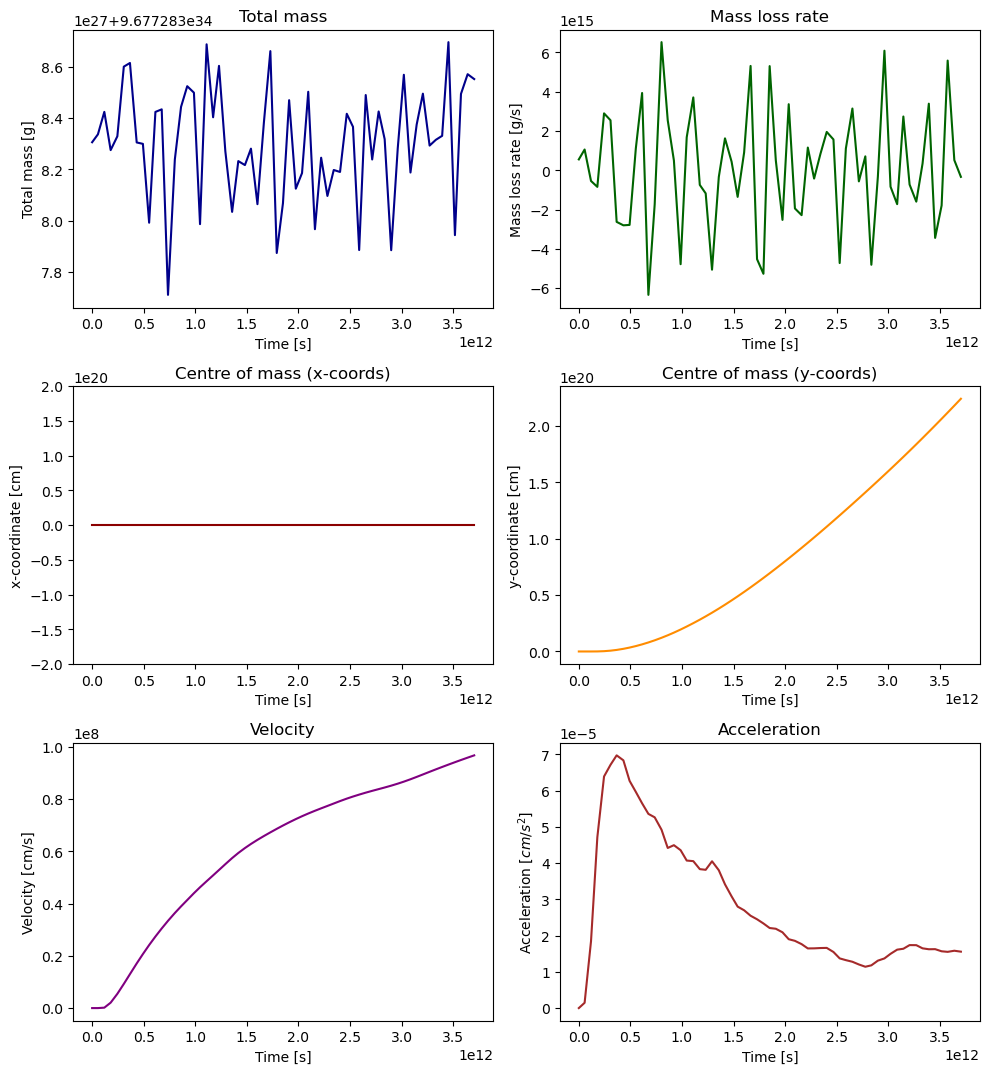

In [42]:
# Create a new figure
fig, ax = plt.subplots(3, 2, figsize=(10,11 ))

plt.subplots_adjust(hspace = 0.4)
# Total mass
ax[0, 0].plot(time_cgs, cloud_mass, color = "darkblue")
ax[0, 0].set_title("Total mass")
ax[0, 0].set_xlabel("Time [s]")
ax[0, 0].set_ylabel("Total mass [g]")

# Mass loss rate 
ax[0, 1].plot(time_cgs, cloud_lm, color = "darkgreen")
ax[0, 1].set_title("Mass loss rate")
ax[0, 1].set_xlabel("Time [s]")
ax[0, 1].set_ylabel("Mass loss rate [g/s]")


# Centre of mass (x-coordinate)
ax[1, 0].plot(time_cgs, cm_x,  color = "darkred")
ax[1, 0].set_title("Centre of mass (x-coords)")
ax[1, 0].set_xlabel("Time [s]")
ax[1, 0].set_ylabel("x-coordinate [cm]")
ax[1, 0].set_ylim(-2e20, 2e20)

# Centre of mass (y-coordinate)
ax[1, 1].plot(time_cgs, cm_y,  color = "darkorange")
ax[1, 1].set_title("Centre of mass (y-coords)")
ax[1, 1].set_xlabel("Time [s]")
ax[1, 1].set_ylabel("y-coordinate [cm]")



# Cloud velocity 
ax[2, 0].plot(time_cgs, v, color = "purple")
ax[2, 0].set_title("Velocity")
ax[2, 0].set_xlabel("Time [s]")
ax[2, 0].set_ylabel("Velocity [cm/s]")

# Cloud acceleration
ax[2, 1].plot(time_cgs, a, color = "brown")
ax[2, 1].set_title("Acceleration")
ax[2, 1].set_xlabel("Time [s]")
ax[2, 1].set_ylabel(r"Acceleration [$cm/s^2$]")

# Adjust layout to prevent overlapping titles and labels
fig.tight_layout()

# Show the plot
plt.show()

Based on this results, we can see that indeed the cloud accelerates, and as time progresses this accelerations decreases, which means that the cloud would reach a constant velocity. 

### (c)
Return a movie showing the time evolution of the cloud density map and the position of the centre of mass of the cloud. Use a marker to indicate the time-dependent position on the density maps.

In [43]:
# Let's create the directory for magnetic field maps
if os.path.isdir("./movie_plots"):
    print("Directory already exists.")
else: 
    print("Directory has been created.")
    os.mkdir("./movie_plots")

movie_directory = "./movie_plots/"

Directory already exists.


In [44]:
# Define a counter to loop over the coordinates of the centre of mass
count = 0

# Loop over all the files 
for i in range(0,len(time_cgs)):
    
    # Define the filename 
    file = directory + "data.0{:03d}.vtk".format(i) 
    
    # Call the function
    data = io_data(file)
    
    # calling the resize function for the vector fields 
    # Resizing magnetic field
    rho_clean2 = rho_cloud(data[2], data[0])
    
    # Plotting 
    
    # Cloud density plot
    fig, ax = plt.subplots(figsize = (6, 5))
    z = ax.pcolor(X_2D, Y_2D, rho_clean2, cmap = "Blues", vmin = 0, vmax = 6e-23)
    clb5 = plt.colorbar(z)
    clb5.set_label(r"$g/cm^3$")
    ax.set_title(f"Cloud density and its centre of mass ")
    ax.set_xlabel("x [cm]")
    ax.set_ylabel("y [cm]")
    
    # Time stamp 
    # Add a new subtitle with the current time step
    subtitle = f"Time [s]:{time_cgs[i]}"
    bbox_props = dict(boxstyle='square,pad=0.3', facecolor='white', edgecolor='black', linewidth = 0.2)
    ax.text(0.5, 0.92, subtitle, transform=ax.transAxes, ha='center', fontsize = 10, bbox=bbox_props)

    # Centre of mass
    ax.plot(cm_x[count], cm_y[count], color = "red", linestyle = "", marker = "o", markersize = 5, label = "Centre of mass")
    
    # Legends
    plt.legend(loc = "lower right", fontsize = 9)
    
    # Save the figure
    plt.savefig(movie_directory + "Cloud_mass_centre_mass{:03d}.png".format(i))
    
    plt.close() 
    
    # re define the counter 
    count += 1 

In [45]:
# Create the animation 
images_input = "./movie_plots/Cloud_mass_centre_mass***.png"
imgif_output = "./Cloud_density.gif"

# Collect the images 
imgs = (Image.open(f) for f in sorted(glob.glob(images_input)))

img = next(imgs)

img.save(fp = imgif_output, format = "GIF", append_images = imgs,\
         save_all = True, duration = 60, loop = 0)

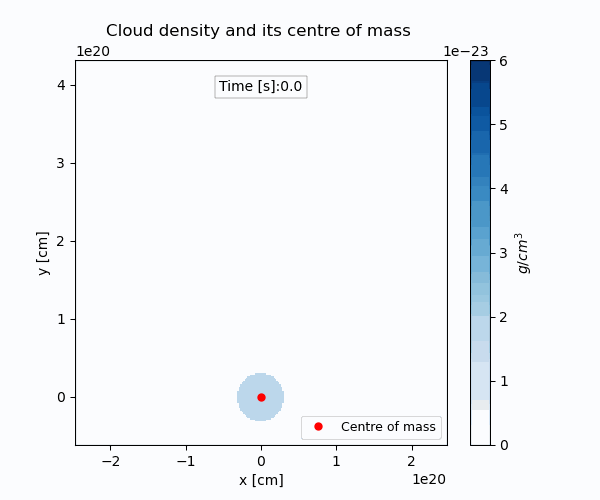

In [46]:
display.Image("./Cloud_density.gif")